# Reconstruction of the ESCO skills hierarchy

This notebook uses [ESCO API](https://ec.europa.eu/esco/api/doc/esco_api_doc.html) to reconstruct the new [ESCO skills hierarchy](https://ec.europa.eu/esco/portal/escopedia/Skills_pillar) (released in May 2020). The final outputs are two tables: `concepts_hierarchy` that contains the structure of the ESCO skills hierarchy, and `skills_final` that contains all items of the ESCO skills pillar and their position in the hierarchy.

In [1]:
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from treelib import Node, Tree

In [2]:
# Import the already prepared skills dataframe (NB: This is not really prerequisite, as one could also recreate this
# dataframe by using the ESCO API, using the requests shown below).
skills = pd.read_csv('../data/processed/item_skills.csv')


# 1. Hierarchy levels for all skills

Here, we access all items of the ESCO skills pillar and check their place in the new skills hierarchy.

## 1.1 API calls

In [4]:
api_folder = '../data/interim/ESCO_skills_API/'

In [106]:
# Use the API to get the hierarchy levels of all 13,000+ skills;
# Note that making all the API calls will take some time
# (alternatively, use the next cell to import the preloaded data)

all_broaderHierarchyConcepts = []
all_skill_uris = []

head_link = 'https://ec.europa.eu/esco/api'

# Load 20 skills at a time
offset = 0
count= 20
while count == 20:
    link = '/resource/skill?isInScheme=http://data.europa.eu/esco/concept-scheme/member-skills&language=en&limit=20&offset='+str(offset)    
    req = requests.get(head_link+link)

    list_of_uris = list(req.json()['_embedded'].keys())
    for j in range(len(list_of_uris)):
        
        k = list_of_uris[j]    
        keys = req.json()['_embedded'][k]['_links'].keys()
        if 'broaderHierarchyConcept' in keys:
            h = req.json()['_embedded'][k]['_links']['broaderHierarchyConcept']
            all_broaderHierarchyConcepts.append(h)
        else:
            all_broaderHierarchyConcepts.append([])

    count = req.json()['count']    
    offset += 20
    all_skill_uris += list_of_uris

pickle.dump(all_broaderHierarchyConcepts, open(api_folder + 'ESCO_skills_all_broaderHierarchyConcepts.pickle','wb'))
pickle.dump(all_skill_uris, open(api_folder + 'ESCO_skills_all_skill_uris.pickle','wb'))


In [5]:
# Import the preloaded skills hierarchy level data
all_broaderHierarchyConcepts = pickle.load(open(api_folder + 'ESCO_skills_all_broaderHierarchyConcepts.pickle','rb'))
all_skill_uris = pickle.load(open(api_folder + 'ESCO_skills_all_skill_uris.pickle','rb'))


## 1.2 Create a dataframe with skill hierarchy levels

In [6]:
n = len(all_broaderHierarchyConcepts)

all_titles = ['']*n
all_uris = ['']*n
all_hrefs = ['']*n
all_codes = ['']*n

for j, h in enumerate(all_broaderHierarchyConcepts):
    if len(h) != 0:
        all_titles[j] = h[0]['title']
        all_uris[j] = h[0]['uri']    
        all_hrefs[j] = h[0]['href']
        if 'code' in list(h[0].keys()):
            all_codes[j] = h[0]['code']
            
print(f'We have hierarchy codes for {len(all_codes)} skills')

We have hierarchy codes for 13485 skills


In [7]:
# Get the different hierarchy level codes for each skill
level_1 = ['']*n
level_2 = ['']*n
level_3 = ['']*n
skill_type = ['']*n

for j, code in enumerate(all_codes):
    if len(code) != 0:
        levels = code.split('.')
        skill_type[j] = levels[0][0]
        level_1[j] = levels[0]
        if len(levels)>1:
            level_2[j] = levels[0] + '.' + levels[1]
        if len(levels)>2:
            level_3[j] = levels[0] + '.' + levels[1] + '.' + levels[2]
            
# Create a dataframe storing skills' hierarchy levels
skill_hierarchy = pd.DataFrame(data={
    'concept_uri': all_skill_uris,
    'code': all_codes,
    'skill_category': skill_type,
    'level_1': level_1,
    'level_2': level_2,
    'level_3': level_3,
    'level_title': all_titles,
    'level_href': all_hrefs
})

# Link the data to the main skills dataframe
skills_ = skills.merge(skill_hierarchy, on='concept_uri', how='left')            

In [8]:
skills_.sample(3)

concept_type  \
4040   KnowledgeSkillCompetence   
13246  KnowledgeSkillCompetence   
9047   KnowledgeSkillCompetence   

                                             concept_uri        skill_type  \
4040   http://data.europa.eu/esco/skill/4c765b1f-9de3...  skill/competence   
13246  http://data.europa.eu/esco/skill/fbf0c677-30f7...  skill/competence   
9047   http://data.europa.eu/esco/skill/ab04dd50-0bdd...         knowledge   

               reuse_level                       preferred_label  \
4040   occupation-specific                   spot other climbers   
13246      sector-specific  operate LED-based panel signal boxes   
9047   occupation-specific       hydrocarbon cracking techniques   

                                              alt_labels  \
4040   spotting of other climbers\ncommunicate with c...   
13246  execute signalling activities using LED-based ...   
9047   technique for hydrocarbon cracking\nmethods to...   

                                             description     id    code  \
4040   Attend to another climber's safety and climbin...   4040  S6.2.4   
13246  Work with high tech LED-based signal boxes; a ...  13246  S5.7.0   
9047   Understand various techniques used to convert ...   9047           

      skill_category level_1 level_2 level_3  \
4040               S      S6    S6.2  S6.2.4   
13246              S      S5    S5.7  S5.7.0   
9047                                           

                                    level_title  \
4040                                   climbing   
13246  using digital tools to control machinery   
9047         chemical engineering and processes   

                                              level_href  
4040   https://ec.europa.eu/esco/api/resource/concept...  
13246  https://ec.europa.eu/esco/api/resource/concept...  
9047   https://ec.europa.eu/esco/api/resource/concept...

# 2. Reconstruct the skills hierarchy structure

Here, we get all labels and relationships between different levels of the new skills hierarchy, create a dataframe describing each skills position in the hierarchy.

## 2.1 API calls

In [38]:
# Main link to use for calling API
main_link = 'https://ec.europa.eu/esco/api/resource/concept?uri='

# Create a queue of URIs to explore the hierarchy
concept_queue = ['http://data.europa.eu/esco/skill/S',
                 'http://data.europa.eu/esco/skill/A',
                 'http://data.europa.eu/esco/skill/L',
                 'http://data.europa.eu/esco/skill/K']

# Concepts dataframe
concepts = pd.DataFrame(data={
    'title': [],
    'code': [],
    'description': [],
    'uri': [],
    'broader_concept_uri': []
})

# Explore the hierarchy
while len(concept_queue) > 0:
    
    concept = concept_queue.pop()
    
    concept_dict = dict()
    
    # API call
    req = requests.get(main_link + concept)
    r = req.json()
    
    # Save concept information
    concept_dict['title'] = r['title']
    concept_dict['uri'] = r['uri']
    
    if code in list(r.keys()):
        concept_dict['code'] = r['code']
    else:
        concept_dict['code'] = ''
        
    if 'description' in list(r.keys()):
        concept_dict['description'] = r['description']
    else:
        concept_dict['description'] = ''
    
    # Save information about other higher/lower level concepts
    keys = list(r['_links'].keys())
    
    # Higher level concepts
    if 'broaderConcept' in keys:
        if len(r['_links']['broaderConcept']) == 1:
            concept_dict['broader_concept_uri'] = r['_links']['broaderConcept'][0]['uri']
        else:
            # In principle, this should never happen... but just for safety
            broader_concepts = []
            for broader_concept in r['_links']['broaderConcept']:
                broader_concepts.append(broader_concept['uri'])
            concept_dict['broader_concept_uri'] = str(broader_concepts)
    else:
        # No broader concept
        concept_dict['broader_concept_uri'] = 'is_top'
    
    # Lower level concepts (add to the queue)
    if 'narrowerConcept' in keys:
        for narrower_concept in r['_links']['narrowerConcept']:
            concept_queue.append(narrower_concept['uri'])
    
    concepts = concepts.append(concept_dict, ignore_index=True)
    print(f"{concept}: {concept_dict['title']}")

http://data.europa.eu/esco/skill/K: knowledge
http://data.europa.eu/esco/isced-f/06: information and communication technologies (icts)
http://data.europa.eu/esco/isced-f/061: information and communication technologies (icts)
http://data.europa.eu/esco/isced-f/0613: software and applications development and analysis
http://data.europa.eu/esco/isced-f/0612: database and network design and administration
http://data.europa.eu/esco/isced-f/0610: information and communication technologies (icts) not further defined
http://data.europa.eu/esco/isced-f/0619: information and communication technologies not elsewhere classified
http://data.europa.eu/esco/isced-f/0611: computer use
http://data.europa.eu/esco/isced-f/068: inter-disciplinary programmes and qualifications involving information and communication technologies (icts)
http://data.europa.eu/esco/isced-f/0688: inter-disciplinary programmes and qualifications involving information and communication technologies (icts)
http://data.europa.eu/

http://data.europa.eu/esco/isced-f/023: languages
http://data.europa.eu/esco/isced-f/0231: language acquisition
http://data.europa.eu/esco/isced-f/0232: literature and linguistics
http://data.europa.eu/esco/isced-f/0239: languages not elsewhere classified
http://data.europa.eu/esco/isced-f/0230: languages not further defined
http://data.europa.eu/esco/isced-f/028: inter-disciplinary programmes and qualifications involving arts and humanities
http://data.europa.eu/esco/isced-f/0288: inter-disciplinary programmes and qualifications involving arts and humanities
http://data.europa.eu/esco/isced-f/020: arts and humanities not further defined
http://data.europa.eu/esco/isced-f/0200: arts and humanities not further defined
http://data.europa.eu/esco/isced-f/022: humanities (except languages)
http://data.europa.eu/esco/isced-f/0220: humanities (except languages) not further defined
http://data.europa.eu/esco/isced-f/0228: inter-disciplinary programmes and qualifications involving humanities
h

http://data.europa.eu/esco/isced-f/0700: engineering, manufacturing and construction not further defined
http://data.europa.eu/esco/isced-f/073: architecture and construction
http://data.europa.eu/esco/isced-f/0730: architecture and construction not further defined
http://data.europa.eu/esco/isced-f/0731: architecture and town planning
http://data.europa.eu/esco/isced-f/0732: building and civil engineering
http://data.europa.eu/esco/isced-f/01: education
http://data.europa.eu/esco/isced-f/018: inter-disciplinary programmes and qualifications involving education
http://data.europa.eu/esco/isced-f/0188: inter-disciplinary programmes and qualifications involving education
http://data.europa.eu/esco/isced-f/011: education
http://data.europa.eu/esco/isced-f/0111: education science
http://data.europa.eu/esco/isced-f/0114: teacher training with subject specialisation
http://data.europa.eu/esco/isced-f/0119: education not elsewhere classified
http://data.europa.eu/esco/isced-f/0110: education 

http://data.europa.eu/esco/skill/S8.5.0: operating machinery for the manufacture of products
http://data.europa.eu/esco/skill/S8.5.1: operating painting or coating machinery
http://data.europa.eu/esco/skill/S8.5.4: operating food processing machinery
http://data.europa.eu/esco/skill/S8.5.7: operating metal, plastic or rubber forming equipment
http://data.europa.eu/esco/skill/S8.5.8: operating cutting, grinding and smoothing machinery
http://data.europa.eu/esco/skill/S8.5.2: operating packaging machinery
http://data.europa.eu/esco/skill/S5: working with computers
http://data.europa.eu/esco/skill/S5.2: setting up and protecting computer systems
http://data.europa.eu/esco/skill/S5.2.2: protecting ict devices
http://data.europa.eu/esco/skill/S5.2.0: setting up and protecting computer systems
http://data.europa.eu/esco/skill/S5.2.3: resolving computer problems
http://data.europa.eu/esco/skill/S5.2.1: setting up computer systems
http://data.europa.eu/esco/skill/S5.1: programming computer sys

http://data.europa.eu/esco/skill/S2.5: measuring physical properties
http://data.europa.eu/esco/skill/S2.5.2: weighing
http://data.europa.eu/esco/skill/S2.5.1: measuring dimensions and related properties
http://data.europa.eu/esco/skill/S2.5.0: measuring physical properties
http://data.europa.eu/esco/skill/S2.7: analysing and evaluating information and data
http://data.europa.eu/esco/skill/S2.7.3: analysing financial and economic data
http://data.europa.eu/esco/skill/S2.7.0: analysing and evaluating information and data
http://data.europa.eu/esco/skill/S2.7.6: evaluating systems, programmes, equipment and products
http://data.europa.eu/esco/skill/S2.7.4: analysing business operations
http://data.europa.eu/esco/skill/S2.7.5: performing risk analysis and management
http://data.europa.eu/esco/skill/S2.7.2: analysing scientific and medical data
http://data.europa.eu/esco/skill/S2.7.1: assessing land or real estate
http://data.europa.eu/esco/skill/S2.3: managing information
http://data.euro

http://data.europa.eu/esco/skill/S1.15.0: using more than one language
http://data.europa.eu/esco/skill/S1.15.2: translating and interpreting
http://data.europa.eu/esco/skill/S1.6: promoting, selling and purchasing
http://data.europa.eu/esco/skill/S1.6.0: promoting, selling and purchasing
http://data.europa.eu/esco/skill/S1.6.3: purchasing goods or services
http://data.europa.eu/esco/skill/S1.6.1: selling products or services
http://data.europa.eu/esco/skill/S1.6.2: promoting products, services, or programs
http://data.europa.eu/esco/skill/S1.3: teaching and training
http://data.europa.eu/esco/skill/S1.3.3: training on operational procedures
http://data.europa.eu/esco/skill/S1.3.0: teaching and training
http://data.europa.eu/esco/skill/S1.3.4: training on health or medical topics
http://data.europa.eu/esco/skill/S1.3.1: teaching academic or vocational subjects
http://data.europa.eu/esco/skill/S1.3.2: teaching safety procedures
http://data.europa.eu/esco/skill/S1.3.5: coaching and mento

http://data.europa.eu/esco/skill/S7.2.2: installing plumbing or piping equipment or systems
http://data.europa.eu/esco/skill/S7.3: finishing interior or exterior of structures
http://data.europa.eu/esco/skill/S7.3.0: finishing interior or exterior of structures
http://data.europa.eu/esco/skill/S7.3.3: applying protective or decorative solutions or coatings
http://data.europa.eu/esco/skill/S7.3.4: installing floor and wall coverings
http://data.europa.eu/esco/skill/S7.3.1: applying material to fill gaps in surfaces
http://data.europa.eu/esco/skill/S7.3.2: appyling textured or masonry coatings


In [179]:
# Format the description column
concepts['description_en'] = concepts.description.apply(lambda x: x['en']['literal'] if type(x)==dict else x)
concepts_hierarchy = concepts.copy()
concepts_hierarchy.drop('description', axis=1, inplace=True)

In [180]:
concepts_hierarchy.head(3)

title code  \
0                                          knowledge        
1  information and communication technologies (icts)        
2  information and communication technologies (icts)        

                                      uri  \
0      http://data.europa.eu/esco/skill/K   
1   http://data.europa.eu/esco/isced-f/06   
2  http://data.europa.eu/esco/isced-f/061   

                     broader_concept_uri description_en  
0                                 is_top                 
1     http://data.europa.eu/esco/skill/K                 
2  http://data.europa.eu/esco/isced-f/06

In [181]:
concepts_hierarchy.tail(3)

title code  \
653         installing floor and wall coverings        
654  applying material to fill gaps in surfaces        
655       appyling textured or masonry coatings        

                                         uri  \
653  http://data.europa.eu/esco/skill/S7.3.4   
654  http://data.europa.eu/esco/skill/S7.3.1   
655  http://data.europa.eu/esco/skill/S7.3.2   

                       broader_concept_uri  \
653  http://data.europa.eu/esco/skill/S7.3   
654  http://data.europa.eu/esco/skill/S7.3   
655  http://data.europa.eu/esco/skill/S7.3   

                                        description_en  
653  Installing various types of floor and wall cov...  
654  Applying various types of material to fill or ...  
655  Applying plaster or similar materials to a sur...

## 2.2 Create codes for knowledge categories

ESCO doesn't provide codes for knowledge categories, as far as I'm aware, but it does contain broader knowledge categories. Hence, for convenience, I generate codes from scratch.

In [182]:
def get_code(x):
    if x[0:33] == 'http://data.europa.eu/esco/skill/':
        return x[33:]
    else:
        return ''
    
concepts_hierarchy['code'] = concepts_hierarchy['uri'].apply(lambda x: get_code(x)) 

In [183]:
# Determine the different high level categories for each concept
concepts_hierarchy['category'] = 'K'
concepts_hierarchy.loc[ concepts_hierarchy.code!='', 'category'] = concepts_hierarchy.loc[concepts_hierarchy.code!='', 'code'].apply(lambda x: x[0])


In [184]:
# Create codes for each knowledge concept
top_concept_queue = ['http://data.europa.eu/esco/skill/K']

# Explore the hierarchy
while len(top_concept_queue) > 0:

    concept = top_concept_queue.pop()
    
    # Get the code
    code = concepts_hierarchy[concepts_hierarchy.uri == concept].code.values[0]
    
    children = concepts_hierarchy[concepts_hierarchy.broader_concept_uri==concept]
    children = children.copy().sort_values('uri').reset_index(drop=True)
    
    for j, row in children.iterrows():
        
        if len(code)==1:
            new_code = code + str(j)
        else:
            new_code = code + '.' + str(j)
            
        concepts_hierarchy.loc[concepts_hierarchy.uri==row.uri, 'code'] = new_code
        top_concept_queue.append(row.uri)

In [185]:
concepts_hierarchy

title    code  \
0                                            knowledge       K   
1    information and communication technologies (icts)      K6   
2    information and communication technologies (icts)    K6.0   
3    software and applications development and anal...  K6.0.3   
4       database and network design and administration  K6.0.2   
..                                                 ...     ...   
651       finishing interior or exterior of structures  S7.3.0   
652  applying protective or decorative solutions or...  S7.3.3   
653                installing floor and wall coverings  S7.3.4   
654         applying material to fill gaps in surfaces  S7.3.1   
655              appyling textured or masonry coatings  S7.3.2   

                                         uri  \
0         http://data.europa.eu/esco/skill/K   
1      http://data.europa.eu/esco/isced-f/06   
2     http://data.europa.eu/esco/isced-f/061   
3    http://data.europa.eu/esco/isced-f/0613   
4    http://data.europa.eu/esco/isced-f/0612   
..                                       ...   
651  http://data.europa.eu/esco/skill/S7.3.0   
652  http://data.europa.eu/esco/skill/S7.3.3   
653  http://data.europa.eu/esco/skill/S7.3.4   
654  http://data.europa.eu/esco/skill/S7.3.1   
655  http://data.europa.eu/esco/skill/S7.3.2   

                        broader_concept_uri  \
0                                    is_top   
1        http://data.europa.eu/esco/skill/K   
2     http://data.europa.eu/esco/isced-f/06   
3    http://data.europa.eu/esco/isced-f/061   
4    http://data.europa.eu/esco/isced-f/061   
..                                      ...   
651   http://data.europa.eu/esco/skill/S7.3   
652   http://data.europa.eu/esco/skill/S7.3   
653   http://data.europa.eu/esco/skill/S7.3   
654   http://data.europa.eu/esco/skill/S7.3   
655   http://data.europa.eu/esco/skill/S7.3   

                                        description_en category  
0                                                             K  
1                                                             K  
2                                                             K  
3    Software and applications development and anal...        K  
4    Database and network design and administration...        K  
..                                                 ...      ...  
651  Applying interior and exterior finishes to bui...        S  
652  Applying paint, lacquer, wallpaper or other co...        S  
653  Installing various types of floor and wall cov...        S  
654  Applying various types of material to fill or ...        S  
655  Applying plaster or similar materials to a sur...        S  

[656 rows x 6 columns]

## 2.3 Final fine-tuning

### 2.3.1 Hierarchy dataframe

In [186]:
# Determine the level of the hierarchy for each concept
def determine_hierarchy_level(x):
    if len(x) == 1:
        return 0
    else:
        return len(x.split('.'))
    
concepts_hierarchy['hierarchy_level'] = concepts_hierarchy.code.apply(lambda x: determine_hierarchy_level(x))

In [207]:
# Add broader concept codes
concepts_hierarchy['broader_concept_code'] = concepts_hierarchy.merge(
    concepts_hierarchy[['code','uri']],
    left_on='broader_concept_uri', right_on='uri', how='left').code_y.to_list()

concepts_hierarchy.loc[concepts_hierarchy.broader_concept_code.isnull(),'broader_concept_code'] = 'is_top'

In [208]:
# Reorganise columns
concepts_hierarchy = concepts_hierarchy[['title', 'category', 'code', 'description_en', 'hierarchy_level',
                                        'broader_concept_code', 'uri', 'broader_concept_uri']]

In [230]:
concepts_hierarchy.head(3)

title category  code  \
0                                          knowledge        K     K   
1  information and communication technologies (icts)        K    K6   
2  information and communication technologies (icts)        K  K6.0   

  description_en  hierarchy_level broader_concept_code  \
0                               0               is_top   
1                               1                    K   
2                               2                   K6   

                                      uri  \
0      http://data.europa.eu/esco/skill/K   
1   http://data.europa.eu/esco/isced-f/06   
2  http://data.europa.eu/esco/isced-f/061   

                     broader_concept_uri  
0                                 is_top  
1     http://data.europa.eu/esco/skill/K  
2  http://data.europa.eu/esco/isced-f/06

### 2.3.2 Skills dataframe

In [286]:
# Account for knowledge and language-use skills
skills_final = skills_.copy()

# Knowledge skills
x = (skills_.skill_category == '') & (skills_.skill_type == 'knowledge')
print(f'There are {np.sum(x)} knowledge types')
skills_final.loc[x,'skill_category'] = 'K'

# Language-using skills
x = (skills_.skill_category == '') & (skills_.skill_type == 'skill/competence')
print(f'There are {np.sum(x)} language skills')
skills_final.loc[x,'skill_category'] = 'L_use'

# Add the knowledge codes
skills_final['level_uri'] = skills_final.level_href.apply(lambda x: x[51:])

df = skills_final[skills_final.skill_category=='K'].merge(
    concepts_hierarchy[['uri','code']],
    left_on='level_uri', right_on='uri', how='left')
skills_final.loc[skills_final.skill_category=='K','code'] = df.code_y.to_list()


There are 2834 knowledge types
There are 285 language skills


### Take care of null values in the `code` column by hand

There are two knowledge items that are even below a Level-3 knowledge type. We all assign them to the same cluster as their higher-level knowledge type

In [287]:
null_df = skills_final[skills_final.code.isnull()]
null_df

concept_type  \
4794   KnowledgeSkillCompetence   
13385  KnowledgeSkillCompetence   

                                             concept_uri skill_type  \
4794   http://data.europa.eu/esco/skill/5a234b3b-63b4...  knowledge   
13385  http://data.europa.eu/esco/skill/fe30a4b0-1a99...  knowledge   

           reuse_level           preferred_label  \
4794   sector-specific          office equipment   
13385     cross-sector  communication principles   

                                              alt_labels  \
4794   office machinery\nequipment found in offices\n...   
13385  communication theories\ncommunication ideals\n...   

                                             description     id code  \
4794   The offered office machinery and equipment pro...   4794  NaN   
13385  The set of commonly shared principles in regar...  13385  NaN   

      skill_category level_1 level_2 level_3 level_title level_href level_uri  
4794               K                                                           
13385              K

In [288]:
broader_skills = []
for j, row in null_df.iterrows():
    concept = row.concept_uri
    req = requests.get(main_link + concept)
    r = req.json()
    broader_skills.append(r['_links']['broaderSkill'])

In [289]:
codes = []
titles = []
for broader_skills_list in broader_skills:
    codes_list = []
    title_list = []
    for b in broader_skills_list:
        title_list.append(skills_final[skills_final.concept_uri==b['uri']].preferred_label.values[0])
        codes_list.append(skills_final[skills_final.concept_uri==b['uri']].id.values[0])
    codes.append(codes_list)
    titles.append(title_list)

In [290]:
codes, titles

([[11313], [8783, 4652]],
 [['product comprehension'], ['teamwork principles', 'diplomatic principles']])

In [291]:
# Assign the knowledge types without code to the same cluster as their higher-level knowledge types
# (communication principles we arbitrarily assign to teamwork principles)
adaptation_list = [[4794, 11313], [13385, 8783]]

In [292]:
cols_to_adapt = ['code', 'skill_category', 'level_1', 'level_2', 'level_3', 'level_title']
for pair in adaptation_list:
    for col in cols_to_adapt:
        skills_final.loc[pair[0], col] = skills_final.loc[pair[1], col]

In [293]:
len(skills_final[skills_final.code.isnull()])

0

### Add values in `level` columns for knowledge items

In [294]:
df = skills_final[skills_final.skill_category=='K'].copy()
all_codes = df.code.to_list()
n = len(all_codes)

# Get the different hierarchy level codes for each skill
level_1 = ['']*n
level_2 = ['']*n
level_3 = ['']*n

for j, code in enumerate(all_codes):
    if len(code) != 0:
        levels = code.split('.')
        level_1[j] = levels[0]
        if len(levels)>1:
            level_2[j] = levels[0] + '.' + levels[1]
        if len(levels)>2:
            level_3[j] = levels[0] + '.' + levels[1] + '.' + levels[2]
            
skills_final.loc[df.id.to_list(), 'level_1'] = level_1
skills_final.loc[df.id.to_list(), 'level_2'] = level_2
skills_final.loc[df.id.to_list(), 'level_3'] = level_3

In [297]:
skills_final


concept_type  \
0      KnowledgeSkillCompetence   
1      KnowledgeSkillCompetence   
2      KnowledgeSkillCompetence   
3      KnowledgeSkillCompetence   
4      KnowledgeSkillCompetence   
...                         ...   
13480  KnowledgeSkillCompetence   
13481  KnowledgeSkillCompetence   
13482  KnowledgeSkillCompetence   
13483  KnowledgeSkillCompetence   
13484  KnowledgeSkillCompetence   

                                             concept_uri        skill_type  \
0      http://data.europa.eu/esco/skill/0005c151-5b5a...  skill/competence   
1      http://data.europa.eu/esco/skill/00064735-8fad...  skill/competence   
2      http://data.europa.eu/esco/skill/000709ed-2be5...  skill/competence   
3      http://data.europa.eu/esco/skill/0007bdc2-dd15...  skill/competence   
4      http://data.europa.eu/esco/skill/00090cc1-1f27...  skill/competence   
...                                                  ...               ...   
13480  http://data.europa.eu/esco/skill/ffef5eb3-a15e...  skill/competence   
13481  http://data.europa.eu/esco/skill/fff0b074-5a76...  skill/competence   
13482  http://data.europa.eu/esco/skill/fff0e2cd-d0bd...         knowledge   
13483  http://data.europa.eu/esco/skill/fff5bc45-b506...  skill/competence   
13484  http://data.europa.eu/esco/skill/fff74a70-4f82...  skill/competence   

               reuse_level                                    preferred_label  \
0          sector-specific                               manage musical staff   
1      occupation-specific                  supervise correctional procedures   
2          sector-specific                    apply anti-oppressive practices   
3          sector-specific  control compliance of railway vehicles regulat...   
4             cross-sector                        identify available services   
...                    ...                                                ...   
13480      sector-specific  remediate healthcare user's occupational perfo...   
13481      sector-specific               install transport equipment lighting   
13482      sector-specific                        natural language processing   
13483         cross-sector                 coordinate construction activities   
13484         cross-sector                  position guardrails and toeboards   

                                              alt_labels  \
0      manage staff of music\ncoordinate duties of mu...   
1      oversee prison procedures\nmanage correctional...   
2      apply non-oppressive practices\napply an anti-...   
3      monitoring of compliance with railway vehicles...   
4      establish available services\ndetermine rehabi...   
...                                                  ...   
13480  restore healthcare user's occupational perform...   
13481  install transport equipment illumination\nfix ...   
13482                                                NLP   
13483  construction progress review\ncoordination of ...   
13484  positioning guardrails and toeboards\nattachme...   

                                             description     id    code  \
0      Assign and manage staff tasks in areas such as...      0  S4.8.1   
1      Supervise the operations of a correctional fac...      1  S4.2.1   
2      Identify oppression in societies, economies, c...      2  S3.3.0   
3      Inspect rolling stock, components and systems ...      3  S3.3.3   
4      Identify the different services available for ...      4  S3.1.3   
...                                                  ...    ...     ...   
13480  Remediate or restore the cognitive, sensorimot...  13480  S3.2.4   
13481  Install lighting elements in transport equipme...  13481  S8.8.1   
13482  The technologies which enable ICT devices to u...  13482  K2.3.1   
13483  Coordinate the activities of several construct...  13483  S1.2.1   
13484  Attach guardrails and toeboards to the scaffol...  13484  S6.8.2   

      skill_category level_1 level_2 level_3  \
0                 

## 2.4. Number of items at each level

In [331]:
no_elements = [0] * len(concepts_hierarchy)
for i, row in concepts_hierarchy.iterrows():
    if row.hierarchy_level == 0:
        no_elements[i] = len(skills_final[skills_final.skill_category == row.code])
    else:
        level = str(row.hierarchy_level)
        no_elements[i] = len(skills_final[skills_final['level_'+level]==row.code])

In [334]:
# Add number of elements to the concepts hierarchy dataframe
concepts_hierarchy = concepts_hierarchy.copy()
concepts_hierarchy['number_of_items'] = no_elements

concepts_hierarchy.sample(5)

title category    code  \
159                          finance, banking and insurance        K  K4.1.2   
435  evaluating systems, programmes, equipment and products        S  S2.7.6   
47                                    literacy and numeracy        K  K0.2.0   
122  humanities (except languages) not elsewhere classified        K  K2.2.5   
335          browsing, searching and filtering digital data        S  S5.5.1   

                                                                                                                                                                                                                                                                                                  description_en  \
159  Finance, banking and insurance is the study of planning, directing, organizing and controlling financial activities and services. It includes the control and monitoring of the financial resources of organizations, institutions and individuals, and the provision of financial services at the corpo...   
435                                                                                                                                                                                 Evaluating and analysing information on the performance of systems, processes, practices, programmes, equipment or products.   
47   Literacy and numeracy are programmes or qualifications arranged mainly for adults, designed to teach fundamental skills in reading, writing and arithmetic. The typical age range of participants can be used to distinguish between detailed field 0011 'Basic programmes and qualifications' and this ...   
122                                                                                                                                                                                                                                                                                                                
335                                                                                                                        Articulating information needs, searching for data, information and content in digital environments, accessing and navigating them. Creating and updating personal search strategies.   

     hierarchy_level broader_concept_code  \
159                3                 K4.1   
435                3                 S2.7   
47                 3                 K0.2   
122                3                 K2.2   
335                3                 S5.5   

                                         uri  \
159  http://data.europa.eu/esco/isced-f/0412   
435  http://data.europa.eu/esco/skill/S2.7.6   
47   http://data.europa.eu/esco/isced-f/0021   
122  http://data.europa.eu/esco/isced-f/0229   
335  http://data.europa.eu/esco/skill/S5.5.1   

                        broader_concept_uri  number_of_items  
159  http://data.europa.eu/esco/isced-f/041               36  
435   http://data.europa.eu/esco/skill/S2.7               45  
47   http://data.europa.eu/esco/isced-f/002                0  
122  http://data.europa.eu/esco/isced-f/022                0  
335   http://data.europa.eu/esco/skill/S5.5               10

## 2.5 Export tables

In [335]:
# Table with the hierarchy structure
concepts_hierarchy.to_csv('../data/processed/ESCO_skills_hierarchy.csv', index=False)

# Table with skills and their position in the hierarchy levels
skills_final.to_csv('../data/processed/skills_ESCO_hierarchy.csv', index=False)

# 3. Inspect the hierarchy
 

In [9]:
concepts_hierarchy = pd.read_csv('../data/processed/ESCO_skills_hierarchy.csv')
skills_final = pd.read_csv('../data/processed/skills_ESCO_hierarchy.csv')

In [16]:
skills_final.head(2)

concept_type  \
0  KnowledgeSkillCompetence   
1  KnowledgeSkillCompetence   

                                         concept_uri        skill_type  \
0  http://data.europa.eu/esco/skill/0005c151-5b5a...  skill/competence   
1  http://data.europa.eu/esco/skill/00064735-8fad...  skill/competence   

           reuse_level                    preferred_label  \
0      sector-specific               manage musical staff   
1  occupation-specific  supervise correctional procedures   

                                          alt_labels  \
0  manage staff of music\ncoordinate duties of mu...   
1  oversee prison procedures\nmanage correctional...   

                                         description  id    code  \
0  Assign and manage staff tasks in areas such as...   0  S4.8.1   
1  Supervise the operations of a correctional fac...   1  S4.2.1   

  skill_category level_1 level_2 level_3                       level_title  \
0              S      S4    S4.8  S4.8.1       supervising a team or group   
1              S      S4    S4.2  S4.2.1  directing operational activities   

                                          level_href  \
0  https://ec.europa.eu/esco/api/resource/concept...   
1  https://ec.europa.eu/esco/api/resource/concept...   

                                 level_uri  
0  http://data.europa.eu/esco/skill/S4.8.1  
1  http://data.europa.eu/esco/skill/S4.2.1

## 3.1 Most prominent categories

78 categories without items


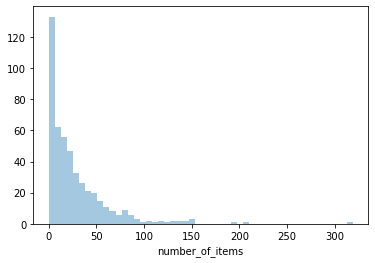

In [10]:
# Note that there are categories without any skills...
df = concepts_hierarchy[concepts_hierarchy.hierarchy_level==3]
print(f"{len(df[df.number_of_items==0])} categories without items")

sns.distplot(concepts_hierarchy[concepts_hierarchy.hierarchy_level==3].number_of_items, bins=50, kde=False)
plt.show()

In [11]:
level_1_counts = skills_final.groupby('level_1').count()[['id']]
level_1_counts['code'] = level_1_counts.index.to_list()
level_1_counts = level_1_counts.merge(concepts_hierarchy[['code', 'title']], on='code').sort_values('id', ascending=False)
level_1_counts


id code                                              title
16  2318   S1        communication, collaboration and creativity
17  2008   S2                                 information skills
21  1464   S6                                handling and moving
23  1369   S8   working with machinery and specialised equipment
19  1317   S4                                  management skills
18  1056   S3                               assisting and caring
11   794   K7        engineering, manufacturing and construction
13   374   K9                                 health and welfare
8    341   K4                   business, administration and law
20   300   S5                             working with computers
10   295   K6  information and communication technologies (icts)
22   283   S7                                       constructing
4    262  K10                                           services
6    258   K2                                arts and humanities
9    236   K5       natural sciences, mathematics and statistics
0    140   A1                                          attitudes
7    120   K3        social sciences, journalism and information
12   115   K8    agriculture, forestry, fisheries and veterinary
14    74   L1                                          languages
1     34   A2                                             values
3     29   K1                                          education
2      9   K0              generic programmes and qualifications
15     3   L2                                classical languages
5      1  K11                                      field unknown

In [12]:
concepts_hierarchy[concepts_hierarchy.broader_concept_code=='K10'].sort_values('code')[['title','code','description_en']]


title   code description_en
57                       services not further defined  K10.0            NaN
49                                  personal services  K10.1            NaN
70           hygiene and occupational health services  K10.2            NaN
65                                  security services  K10.3            NaN
59                                 transport services  K10.4            NaN
63  inter-disciplinary programmes and qualificatio...  K10.5            NaN
61                  services not elsewhere classified  K10.6            NaN

## 3.2 Visualise the hierarchy

In [13]:
def create_tree(max_level=3):
    tree = Tree()
    # Create the base node
    tree.create_node("esco skills", "is_top")
    # Add all nodes
    for i, row in concepts_hierarchy.sort_values('code').iterrows():
        if row.hierarchy_level <= max_level:
            tree.create_node(f"{row.code}: {row.title} [{row.number_of_items}]", row.code, parent=row.broader_concept_code)
    return tree 

In [14]:
tree = create_tree(2)
tree.show()

esco skills
├── A: attitudes and values [174]
│   ├── A1: attitudes [140]
│   │   ├── A1.0: attitudes [0]
│   │   ├── A1.10: manage frustration [2]
│   │   ├── A1.12: manage quality [43]
│   │   ├── A1.13: meet commitments [19]
│   │   ├── A1.14: persist [15]
│   │   ├── A1.15: work efficiently [5]
│   │   ├── A1.16: work independently [9]
│   │   ├── A1.1: adapt to change [11]
│   │   ├── A1.2: attend to detail [4]
│   │   ├── A1.3: attend to hygiene [5]
│   │   ├── A1.4: cope with pressure [13]
│   │   ├── A1.5: deal with uncertainty [5]
│   │   ├── A1.6: demonstrate curiosity [1]
│   │   ├── A1.7: demonstrate enthusiasm [2]
│   │   ├── A1.8: demonstrate willingness to learn [5]
│   │   └── A1.9: make an effort [1]
│   └── A2: values [34]
│       ├── A2.0: values [0]
│       ├── A2.1: demonstrate consideration [16]
│       ├── A2.2: demonstrate good manners [6]
│       └── A2.3: follow ethical code of conduct [12]
├── K: knowledge [2834]
│   ├── K0: generic programmes and qualificati